Libraries


In [36]:

# # Installing libraries
using Pkg
# Pkg.add("JuMP")
# # Pkg.add("Gurobi")
# Pkg.add("CSV")
# Pkg.add("XLSX")
# Pkg.add("DataFrames")
# # Pkg.add("PyPlot")
# Pkg.add("Plots")
# Pkg.add("GLPK")
# Pkg.add("Ipopt")
# Pkg.add("Gurobi")

# using Pkg
# Pkg.add("MosekTools")

# # Pkg.add("PythonCall")

# Pkg.add("LaTeXStrings")

# Load libraries
using JuMP, Gurobi, CSV, XLSX, DataFrames, Plots, GLPK, Random, LaTeXStrings



 Criticality values, power rating, and Labels/category

In [37]:
# Generated data with given plot in another python file
# Data
criti = [66, 14, 770, 300, 957, 486, 75, 611, 537, 214]
labels = ["SI", "NSNI", "SI", "SI", "NSNI", "SNI", "NSNI", "SNI", "SI", "SI"]
pawar = [0.6, 1.1, 1.2, 0.5, 0.8, 1.5, 0.6, 0.7, 1.0, 0.8]

10-element Vector{Float64}:
 0.6
 1.1
 1.2
 0.5
 0.8
 1.5
 0.6
 0.7
 1.0
 0.8

In [38]:
using JuMP, CSV, XLSX, DataFrames, Plots, Gurobi

C = criti

# Data for appliances
appliance_names = labels

power = pawar
start_time = [1, 5,  4, 8,  12,  14,  9,  12, 11, 19]
end_time =  [6, 8, 13, 15, 16, 20, 19, 18, 17, 23]
d = [1, 2,  1,  4,  1,  2,  3,  1,  2, 1]  # Appliance durations 

L = length(appliance_names)  # Number of loads
T = 24  # Total time, 24 hours

# Data for the solar plant 6kW (8.55kWh/day), Brookings OCT 12, 2019

P_PV = [0, 0, 0, 0, 0, 0, 0.101, 0.544, 0.973, 1.393, 1.43, 1.361, 1.365, 1.152, 0.682, 0.292, 0.066, 0, 0, 0, 0, 0, 0, 0]

λ = 0.2
# Constants
E_total = 3.5               # Battery capacity in kWh
SOC_min = 0.1 * E_total     # Minimum SOC
SOC_max = 0.9 * E_total     # Maximum SOC
ηc = 0.95                   # Charging efficiency
ηd = 0.95                   # Discharging efficiency
initial_SOC = 0.8 * E_total # Initial SOC (80% of E_total)
final_SOC = 0.2 * E_total   # Final SOC (20% of E_total)

# Power limits
Pbc_max = 1.0  # Max charging power in kW
Pbc_min = 0.0  # Min charging power in kW
Pbd_max = -1.0  # Max discharging power in kW
Pbd_min = 0.0  # Min discharging power in kW

times = 1:T


# Create model
model = Model(Gurobi.Optimizer)

# Decision variables
@variable(model, x[1:L, 1:T], Bin)  # Binary decision variable for appliances
@variable(model, y[1:L, 1:T], Bin)  # Auxiliary binary variable for non-interruptible devices

@variable(model, P_bc[1:T])             # Charging power, battery
@variable(model, P_bd[1:T])             # Discharging power, battery

@variable(model, P_curtail[1:T])        # Curtailed power
@variable(model, SOC[1:T])                   # State of charge

@variable(model, Bc[1:T], Bin)               # Binary charging status
@variable(model, Bd[1:T], Bin)               # Binary discharging status


@variable(model, skip[i=1:L], Bin)  # Binary variable for skipping appliance, where power doesn't met load requirments or not possible to complete the assigned duration


# Objective function: Maximize served load and minimize curtailment
@objective(model, Max, 
    sum(C[i] * x[i, t] for i in 1:L for t in 1:T) - 0.2 * sum(P_curtail[t] for t in 1:T)
)





# Power balance equaton
for t in 1:T
    @constraint(model, sum(power[i] * x[i, t] for i in 1:L) + P_bc[t] * Bc[t] + P_curtail[t] == P_PV[t] - P_bd[t] * Bd[t] )
end

# Stop simultaneous charging and discharging
for t in 1:T
    @constraint(model, Bc[t] + Bd[t] <= 1)
end

# SOC estimation
for t in 1:T
    if t == 1
        # Initial SOC, when t is 1
        @constraint(model, SOC[t] == initial_SOC + (ηc * P_bc[t] * Bc[t] + (P_bd[t] * Bd[t])/ ηd)/E_total)
    else
        # consider this equation for SOC update when t > 1
        @constraint(model, SOC[t] == SOC[t - 1] + (ηc * P_bc[t] * Bc[t] + (P_bd[t] * Bd[t])/ ηd)/E_total)
    end
end




# Battery charging power limits
@constraint(model, [t in 1:T], Pbc_min <= P_bc[t] <= Pbc_max)

# Battery discharging power limits
@constraint(model, [t in 1:T], Pbd_min >= P_bd[t] >= Pbd_max)

# SOC bounds 
@constraint(model, [t in 1:T], SOC_min <= SOC[t] <= SOC_max)

# Initial SOC constraint
# @constraint(model, SOC[1] == initial_SOC)

# Final SOC constraint
@constraint(model, SOC[T] >= final_SOC)

# Power Curtailment constraint, need to modify it

@constraint(model, [t in 1:T], P_curtail[t] >= 0)






# SI Devices (Schedulable and Interruptible)

# Get indices of SI devices
si_indices = findall(x -> x == "SI", appliance_names)

# Loop through SI devices
for i in si_indices
    # Total duration constraint, to ensure the device operates for exactly its duration if not skipped
    @constraint(model, sum(x[i, t] for t in 1:T) == (1 - skip[i]) * d[i])

    for t in 1:T
        # Appliance cannot operate before its allowed time window
        if t < start_time[i] || t >= end_time[i]
            @constraint(model, x[i, t] == 0)  # Cannot operate after allowed time window
        end
    end
end







# Get indices of SNI devices
sni_indices = findall(x -> x == "SNI", appliance_names) 

#  loop to iterate only over SNI devices
for i in sni_indices
    for t in 1:T
        # Constraint for non-interruptibility (can’t turn off once started)
        @constraint(model, x[i, t] <= 1 - y[i, t])
    end

    for t in 2:T
        # Manage transitions, to show If device turns off, transition must be recorded
        @constraint(model, x[i, t - 1] - x[i, t] <= y[i, t])
        # for consistency in transitions, cannot go back to a previous state
        @constraint(model, y[i, t - 1] <= y[i, t])
    end


    @constraint(model, sum(x[i, t] for t in 1:T) == (1 - skip[i]) * d[i])

    for t in 1:T
        # Appliance cannot operate before its allowed time window
        if t < start_time[i] || t >= end_time[i]
            @constraint(model, x[i, t] == 0)  # Cannot operate after allowed time window
        end
    end
end







# for  NSNI loads
# Get indices of NSNI devices
nsni_indices = findall(x -> x == "NSNI", appliance_names)

# Loop through NSNI devices
for i in nsni_indices
    for t in 1:T
        # Ensure device operates only for the specified time 
        if t >= start_time[i] && t < start_time[i] + d[i]
            @constraint(model, x[i, t] <= 1 - skip[i])  # Operate only if not skipped
        else
            # Load must be inactive outside the fixed duration
            @constraint(model, x[i, t] == 0)
        end
    end
    # Run for full duration or skipped
    @constraint(model, sum(x[i, t] for t in start_time[i]:(start_time[i] + d[i] - 1)) == (1 - skip[i]) * d[i])
end







# Solve the optimization problem
optimize!(model)

# Print results
println("Objective Value: ", objective_value(model))
for i in 1:L
    for t in 1:T
        if value(x[i, t]) > 0.5  # Show the appliances that Turned-ON during whole T
            println("Appliance: ", appliance_names[i], " Time: ", t, " Power: ", power[i])
        end
    end
end

# Extract and display results
SOC_results = value.(SOC)
P_bc_results = value.(P_bc)
P_bd_results = value.(P_bd)
load_served = [sum(value(x[i, t]) for i in 1:L) for t in times]
P_curtailed = [sum(value(P_curtail[t]) for i in 1:L) for t in times]


# print the output
println("SOC : ", SOC_results)
println("Charging power values (P_bc): ", P_bc_results)
println("Discharging power (P_bd): ", P_bd_results)
println("Load Served: ", load_served)
println("Power Curtailed: ", P_curtailed)



Set parameter Username
Set parameter LicenseID to value 2586663
Academic license - for non-commercial use only - expires 2025-11-18
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-14700, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 28 logical processors, using up to 28 threads

Optimize a model with 468 rows, 706 columns and 930 nonzeros
Model fingerprint: 0x5a43f657
Model has 48 quadratic constraints
Variable types: 168 continuous, 538 integer (538 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  QMatrix range    [3e-01, 1e+00]
  QLMatrix range   [5e-01, 2e+00]
  Objective range  [2e-01, 1e+03]
  Bounds range     [4e-01, 3e+00]
  RHS range        [7e-01, 4e+00]
  QRHS range       [7e-02, 3e+00]
Presolve removed 438 rows and 524 columns
Presolve time: 0.02s
Presolved: 222 rows, 230 columns, 625 nonzeros
Variable types: 144 continuous, 86 integer (86 binary)
Found heuristic solution

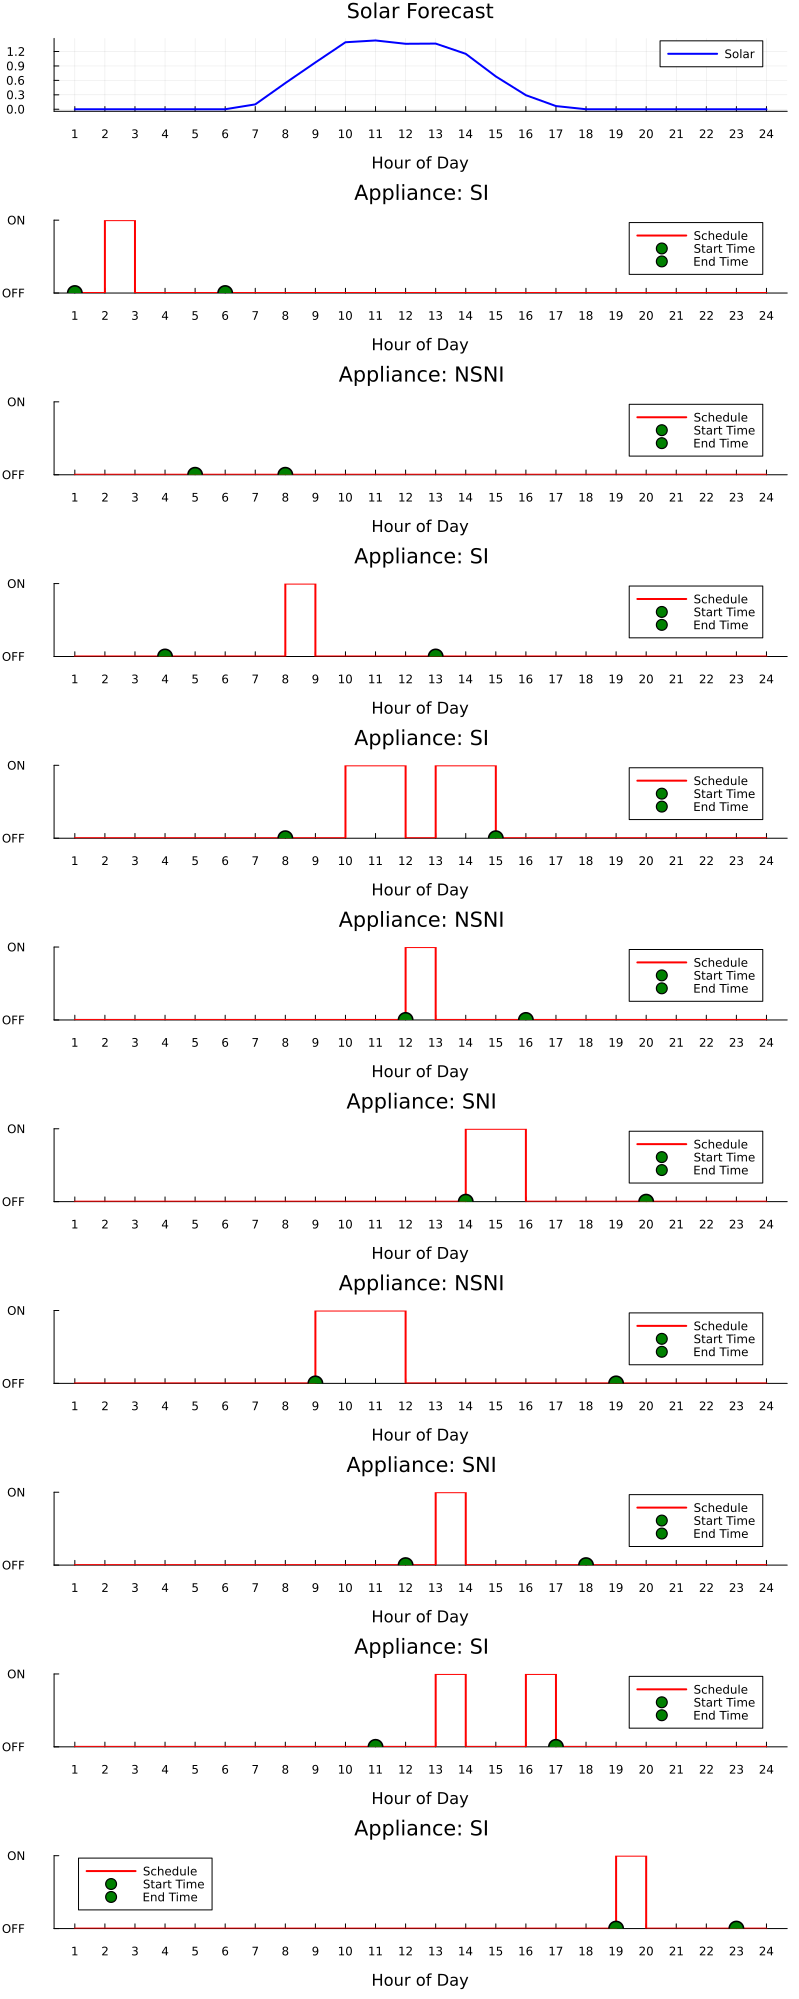

In [39]:
using Plots  

#  data 
L = length(appliance_names)  # Number of appliances=10
T = 24  # for whole day
p_v = P_PV  #  actual solar data
output_matrix = [value(x[i, t]) for i in 1:L, t in 1:T]  # binary results from  above simulated model


# Initialize subplots
plot_list = []

# Plot Solar Power
p_p = plot(1:T, p_v,
             label="Solar",
             lw=2,
             xlabel="Hour of Day",
             ylabel="Price (or Power)",
             title="Solar Forecast",
             color=:blue,
             grid=true,
             xticks=1:1:24)
push!(plot_list, p_p)

# Plot appliance schedules
for i in 1:L
    # Create binary representation of Shifted Schedule
    shifted_rect = zeros(Float64, T)
    for t in 1:T
        if output_matrix[i, t] == 1
            shifted_rect[t] = 1
        end
    end
    p = plot(1:T, shifted_rect,
        label="Schedule",
        lw=2,
        color=:red,
        xlabel="Hour of Day",
        ylabel="Status",
        title="Appliance: $(appliance_names[i])",
        grid=false,
        ylims=(0, 1),  #  range
        yticks=([0,1],["OFF","ON"]),  # set y-axis at 0 and 1
        xticks=1:1:24,
        seriestype=:step)  # create rectangles/step for ON/off

    #  start and end times for each load
    scatter!([start_time[i]], [0],
             label="Start Time",
             color=:green,
             marker=:circle,
             ms=8)
    scatter!([end_time[i]], [0],
             label="End Time",
             color=:green,
             marker=:circle,
             ms=8)

    push!(plot_list, p)
end

# Combine all plots in one figure
final_plot = plot(plot_list..., layout=(L + 1, 1), size=(800, 2000))  # for height/size

# Save plot and display
savefig(final_plot, "scheduling_results_updated without curtailment.pdf")
display(final_plot)



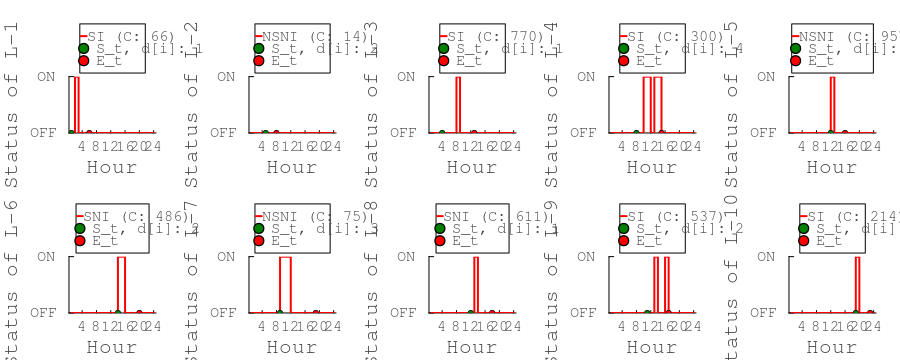

In [40]:
using Plots


num_rows = 2


# Initialize subplots
plot_list = []

# Plot appliance schedules
for i in 1:L
    # Create binary representation of Shifted Schedule
    shifted_rect = zeros(Float64, T)
    for t in 1:T
        if output_matrix[i, t] == 1
            shifted_rect[t] = 1
        end
    end

    # Create plot for each appliance
    p = plot(1:T, shifted_rect,
            label="$(appliance_names[i]) (C: $(criti[i]))",
            lw=2,
            color=:red,
            xlabel="Hour",
            ylabel="Status of L-$(i)",
            # title="L-$(i)",  # Add load number to title  ↓
            grid=false,
            ylims=(0, 1),
            yticks=([0,1],["OFF","ON"]),
            xticks=0:4:24, 
            seriestype=:step,
            margin=10Plots.px, 
            legend=:topleft,
            fontfamily="Times New Roman", 
            fontsize=6
        )

    # Add start and end times
    scatter!(p, [start_time[i]], [0],
            label=" S_t, d[i]: $(d[i])",
            color=:green,
            marker=:circle,
            ms=3)
    scatter!(p, [end_time[i]], [0],
            label=" E_t",
            color=:red,
            marker=:circle,
            ms=3)

    # Push plot to the list
    push!(plot_list, p)
end



num_cols = ceil(Int, length(plot_list) / num_rows) 

# Combine all plots in a 3x3 grid
final_plot = plot(plot_list..., 
            layout=(num_rows, num_cols), 
            size=(900, 180 * num_rows), 
            margin=16Plots.px, 
            legend=:outertop, 
            fontfamily="Times New Roman", 
            fontsize=12
        ) 

# Save plot and display
savefig(final_plot, "1 scheduling_results_with_adjusted_margins.pdf")
savefig(final_plot, "1 scheduling_results_with_adjusted_margins.png")

display(final_plot)

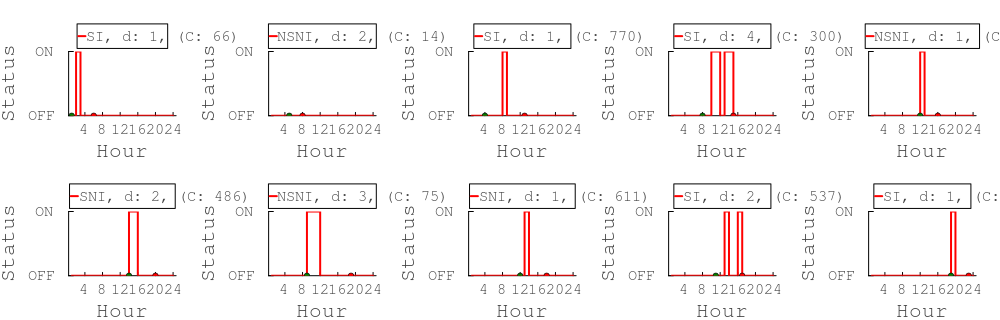

In [41]:
using Plots

num_rows = 2

# Initialize subplots
plot_list = []

# Plot appliance schedules
for i in 1:L
    # Create binary representation of Shifted Schedule
    shifted_rect = zeros(Float64, T)
    for t in 1:T
        if output_matrix[i, t] == 1
            shifted_rect[t] = 1
        end
    end

    # Create plot for each appliance
    p = plot(1:T, shifted_rect,
            label="$(appliance_names[i]), d: $(d[i]), (C: $(C[i]))",
            lw=2,
            color=:red,
            xlabel="Hour",
            ylabel="Status",
            grid=false,
            ylims=(0, 1),
            yticks=([0,1],["OFF","ON"]),
            xticks=0:4:24, 
            seriestype=:step,
            margin=10Plots.px, 
            legend=:topleft, 
            fontfamily="Times New Roman", 
            fontsize=8,
            titlevisible=false  # Hide the plot title
        )

    # Add start and end times without legend
    scatter!(p, [start_time[i]], [0],
             color=:green,
             marker=:circle,
             ms=3,
             label="") 
    scatter!(p, [end_time[i]], [0],
             color=:red,
             marker=:circle,
             ms=3,
             label="")

    # Push plot to the list
    push!(plot_list, p)
end

num_cols = ceil(Int, length(plot_list) / num_rows) 

# Combine all plots in a 3x3 grid
final_plot = plot(plot_list..., 
                 layout=(num_rows, num_cols), 
                 size=(1000, 160 * num_rows), 
                 margin=16Plots.px, 
                 legend=:outertop, 
                 fontfamily="Times New Roman", 
                 fontsize=12,
                 title=""  # Add the plot title
             ) 

# Add the load number as legend title 
for i in 1:length(plot_list)
    plot!(plot_list[i], legendtitle="L" * string(i), legend=true) 
end

# Save plot and display
savefig(final_plot, "1 1 scheduling_results_with_LATEST.pdf")
display(final_plot)

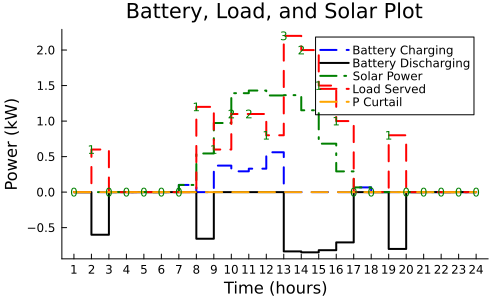

In [42]:


# time total
times = 1:T

# Extract values
battery_charge = [value(P_bc[t]) for t in times]  # Battery charging power
battery_discharge = [value(P_bd[t]) for t in times]  # Battery discharging
solar_power = [P_PV[t] for t in times]                          # Solar power
load_served = [sum(value(x[i, t]) * power[i] for i in 1:L) for t in times]  # Power scheduled for loads that are Turned-ON

# Calculate the number of loads that are "on" and round to whole numbers
loads_on_count = [round(Int, sum(value(x[i, t]) for i in 1:L)) for t in times]

# P Curtail
P_curtaill = [value(P_curtail[t]) for t in times]

# Plot for Battery Charging, Discharging, Load Served, P-curtail, and Solar Power
p1 = plot(
    times, battery_charge, seriestype=:steppost, size=(500, 150 * num_rows), fontsize=10, label="Battery Charging", color=:blue, 
    legend_background_color=:transparent, legend_bordercolor=:transparent,  linewidth=2, linestyle=:dash, xlabel="Time (hours)", ylabel="Power (kW)", title="Battery, Load, and Solar Plot", legend=:topright, xticks=1:T, grid=false  # Remove grid
)
plot!(times, battery_discharge, seriestype=:steppost, label="Battery Discharging", color=:black, linewidth=2)  # Discharging
plot!(times, solar_power, seriestype=:steppost, label="Solar Power", color=:green, linewidth=2, linestyle=:dashdot)
plot!(times, load_served, seriestype=:steppost, label="Load Served", color=:red, linewidth=2, linestyle=:dash)  # Load Served
plot!(times, P_curtaill, seriestype=:steppost, label="P Curtail", color=:orange, linewidth=2, linestyle=:dash)  # Curtailed Power

# Cap values for loads ON
for t in times
    annotate!(t, load_served[t], text(string(loads_on_count[t]), :green, 8, :center))
end

# Save
savefig("1 battery_solar_load_step_plot, with p_curtail addreeeeeeessing.pdf")

display(p1)



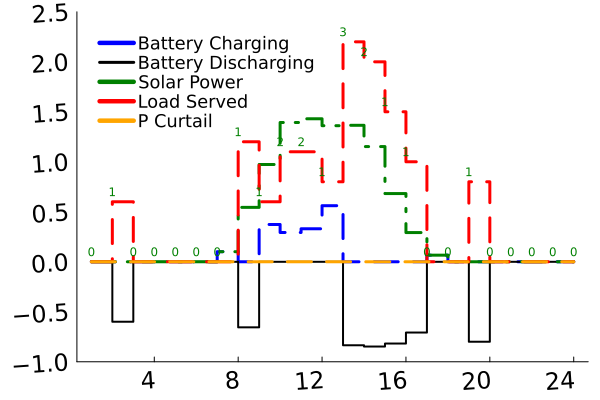

In [43]:
using Plots



# time total
times = 1:T
fontsize = 16

# Extract values
battery_charge = [value(P_bc[t]) for t in times]
battery_discharge = [value(P_bd[t]) for t in times]
solar_power = [P_PV[t] for t in times]
load_served = [sum(value(x[i, t]) * power[i] for i in 1:L) for t in times]

# Calculate the number of loads that are "on" and round to whole numbers
loads_on_count = [round(Int, sum(value(x[i, t]) for i in 1:L)) for t in times]

# P Curtail
P_curtaill = [value(P_curtail[t]) for t in times]

# Plot for Battery Charging, Discharging, Load Served, P-curtail, and Solar Power
p1 = plot(
    times, battery_charge,
    seriestype=:steppost,
    size=(600, 200 * num_rows), 
    fontsize=18,
    label="Battery Charging",
    color=:blue,
    linewidth=2,
    linestyle=:dash,
    grid=false,
    lw=3,
    legend=:topleft,
    guidefont=font(fontsize),
    tickfont=font(fontsize),
    fg_legend =:Transparent,
    legend_background_color=:transparent,  # Set the legend background to transparent
    legend_bordercolor=:transparent,  
    y_guidefontcolor=:black,
    y_foreground_color_axis=:transparent,
    y_foreground_color_text=:transparent,
    ytickfontcolor=:black,
    xticks=0:4:24,
    ylims=[-1, 2.5],
    legendfont=font(12),
    xaxis=(linewidth=4),
    yaxis=(linewidth=4)
)
plot!(times, battery_discharge, seriestype=:steppost, label="Battery Discharging", color=:black, linewidth=2)
plot!(times, solar_power, seriestype=:steppost, label="Solar Power", color=:green, linewidth=3, linestyle=:dashdot)
plot!(times, load_served, seriestype=:steppost, label="Load Served", color=:red, linewidth=3, linestyle=:dash)
plot!(times, P_curtaill, seriestype=:steppost, label="P Curtail", color=:orange, linewidth=3, linestyle=:dash)

# Cap values for loads ON 
for t in times
    annotate!(t, load_served[t] + 0.1, text(string(loads_on_count[t]), :green, 8, :center))
end

# Save
savefig("1 1 battery_solar_load_step_latest.pdf")

# Display
display(p1)


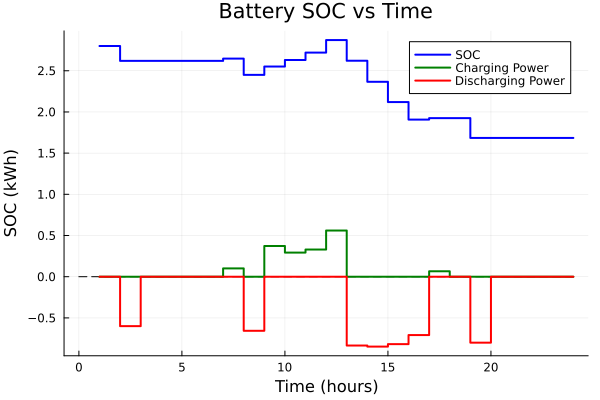

"c:\\Users\\arshid.ali\\OneDrive - South Dakota State University - SDSU\\1 My Work\\A PHD WORK\\To Github\\battery_soc_plotttt.pdf"

In [44]:
using Plots

# Define the given SOC data
SOC = value.(SOC) 

# times is same for all soc time
times = 1:length(SOC) 

# Calculate battery charging and discharging power 
battery_charge = [value(P_bc[t]) for t in times] 
battery_discharge = [value(P_bd[t]) for t in times]

# Time vector 
T = length(SOC)
time_steps = 1:T

# Plotting the results
plot_obj = plot(
    time_steps, 
    SOC, 
    seriestype=:steppost, 
    label="SOC", 
    xlabel="Time (hours)", 
    ylabel="SOC (kWh)", 
    title="Battery SOC vs Time", 
    color=:blue, 
    linewidth=2
)

# Add horizontal axis at 0 for SOC
plot!([0, T], [0, 0], color=:black, linestyle=:dash, label="")

# Optional: Plot charging and discharging power
if !isempty(battery_charge) && !isempty(battery_discharge)
    plot!(plot_obj, time_steps, battery_charge, seriestype=:steppost, label="Charging Power", secondary=true, color=:green, linewidth=2)
    plot!(plot_obj, time_steps, battery_discharge, seriestype=:steppost, label="Discharging Power", secondary=true, color=:red, linewidth=2)
end

# Show
display(plot_obj)

# save plot
savefig(plot_obj, "battery_soc_plotttt.pdf")




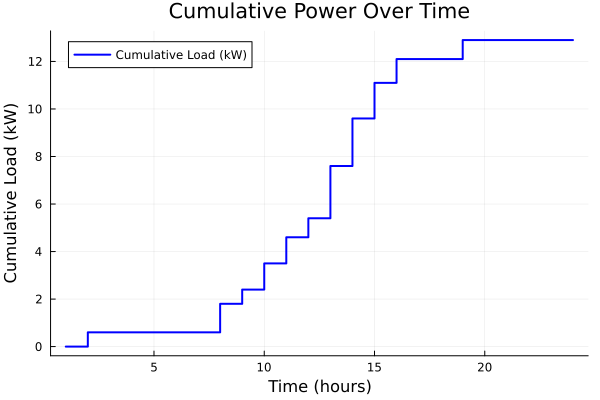

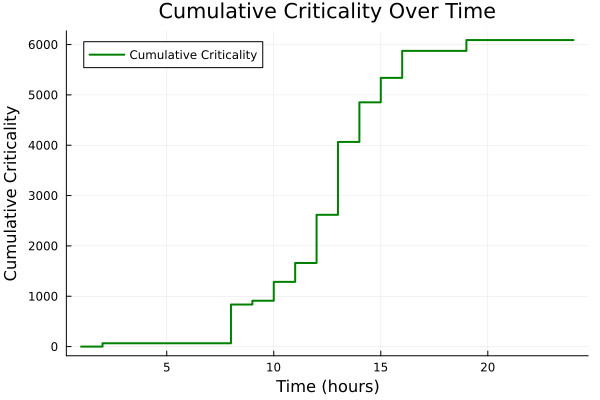

24-element Vector{Float64}:
 0.0
 0.6
 0.0
 0.0
 0.0
 0.0
 0.0
 1.2
 0.6
 1.1
 ⋮
 1.0
 0.0
 0.0
 0.8
 0.0
 0.0
 0.0
 0.0
 0.0

In [45]:


# time range
times = 1:T

# loads served
load_served = [sum(value(x[i, t]) * power[i] for i in 1:L) for t in times]  # Power scheduled for loads that are Turned-ON

cumulative_load = cumsum(load_served)                                     # Cumulative load
cumulative_criticality = cumsum([sum(C[i] * value(x[i, t]) for i in 1:L) for t in times])  # Cumulative criticality

# Plot, Cumulative Load
p1 = plot(
    times, cumulative_load, seriestype=:steppost, label="Cumulative Load (kW)", color=:blue, linewidth=2, xlabel="Time (hours)", ylabel="Cumulative Load (kW)", title="Cumulative Power Over Time"
)

# Save and display the Cumulative Load
savefig("cumulative_load.pdf")
display(p1)

# Plot, Cumulative Criticality
p2 = plot(
    times, cumulative_criticality, seriestype=:steppost, label="Cumulative Criticality", color=:green, linewidth=2, xlabel="Time (hours)", ylabel="Cumulative Criticality", title="Cumulative Criticality Over Time"
)

# Save and display Cumulative Criticality plot
savefig("cumulative_criticality.pdf")
display(p2)

load_served

In [46]:
using DataFrames


load_served = [sum(value(x[i, t]) * power[i] for i in 1:L) for t in times]  # Power scheduled for loads that are Turned-ON

# Create a DataFrame
d = DataFrame(
    Time = times,
    LoadPowerServed = load_served
)

# Print the DataFrame
println(d)
d



# Calculate cumulative criticality
cumulative_criticality = [sum(C[i] * value(x[i, t]) for i in 1:L) for t in times]

# Create a DataFrame
df = DataFrame(
    Time = times,
    Criticality = cumulative_criticality
)

# Print the DataFrame
println(df)
df







# Sample battery_discharge array 
battery_discharge

# Create the DataFrame
bf = DataFrame(
    Time = 1:length(battery_discharge),  # Generate Time values based on array length
    BatteryDischarge = - battery_discharge
)

# Print the DataFrame
println(bf)








24×2 DataFrame
 Row │ Time   LoadPowerServed 
     │ Int64  Float64         
─────┼────────────────────────
   1 │     1              0.0
   2 │     2              0.6
   3 │     3              0.0
   4 │     4              0.0
   5 │     5              0.0
   6 │     6              0.0
   7 │     7              0.0
   8 │     8              1.2
   9 │     9              0.6
  10 │    10              1.1
  11 │    11              1.1
  12 │    12              0.8
  13 │    13              2.2
  14 │    14              2.0
  15 │    15              1.5
  16 │    16              1.0
  17 │    17              0.0
  18 │    18              0.0
  19 │    19              0.8
  20 │    20              0.0
  21 │    21              0.0
  22 │    22              0.0
  23 │    23              0.0
  24 │    24              0.0
24×2 DataFrame
 Row │ Time   Criticality 
     │ Int64  Float64     
─────┼────────────────────
   1 │     1          0.0
   2 │     2         66.0
   3 │     3          0.

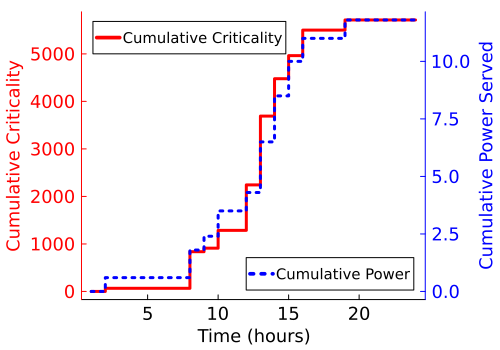

┌ Warning: Skipped yaxis arg right
└ @ Plots C:\Users\arshid.ali\.julia\packages\Plots\Ec1L1\src\axes.jl:76


In [47]:
using DataFrames, Plots

# Create the Criticality DataFrame obtained above, focused to show the results on load served basis
df_criticality = DataFrame(
    Row = 1:24,
    Time = 1:24,
    Criticality = [0.0, 66.0, 0.0, 0.0, 0.0, 0.0, 0.0, 770.0, 75.0, 375.0, 
        0.0, 957.0, 1448.0, 786.0, 486.0, 537.0, 0.0, 0.0, 214.0, 
        0.0, 0.0, 0.0, 0.0, 0.0]
)

# Calculate cumulative criticality
df_criticality.CumulativeCriticality = cumsum(df_criticality.Criticality)

# Create the Load Power Served DataFrame obtained abovve, with focusing to show the results on load served basis
df_load = DataFrame(
    Row = 1:24,
    Time = 1:24,
    LoadPowerServed = [0.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 1.2, 0.6, 1.1, 0.0, 0.8, 2.2, 2.0, 1.5, 
        1.0, 0.0, 0.0, 0.8, 0.0, 0.0, 0.0, 0.0, 0.0]
)

# Calculate cumulative load power served
df_load.CumulativeLoadPowerServed = cumsum(df_load.LoadPowerServed)

# Plot settings
fontsize = 12  # Adjust font size
figsize = (500, 350)  # Set figure size

# Initialize the primary y-axis plot
p = plot(
    df_criticality.Time, df_criticality.CumulativeCriticality,
    seriestype = :steppost,
    xlabel = "Time (hours)",
    ylabel = "Cumulative Criticality",
    label = "Cumulative Criticality", 
    lw = 3,
    linecolor = :red,
    grid = :y,
    legend = :topleft,
    size = figsize,
    guidefont = font(fontsize),
    tickfont = font(fontsize),
    legendfont = font(10),
    y_guidefontcolor=:red,
    y_foreground_color_axis=:red,
    y_foreground_color_text=:red,
    ytickfontcolor=:red,
    # linestyle=:dashdot,
    y_foreground_color_border=:red,)
# Add a secondary y-axis plot using twinx()
ax2 = twinx()
plot!(
    ax2,
    df_load.Time, df_load.CumulativeLoadPowerServed,
    seriestype = :steppost,
    yaxis = :right,
    ylabel = "Cumulative Power Served",
    label = "Cumulative Power",
    lw = 3,
    linecolor = :blue,
    legend = :bottomright,
    guidefont = font(fontsize),
    tickfont = font(fontsize),
    y_guidefontcolor=:blue,
    y_foreground_color_axis=:blue,
    y_foreground_color_text=:blue,
    ytickfontcolor=:blue,
    linestyle=:dot,
    y_foreground_color_border=:blue,
    legendfont = font(10)
)


# Save the plot
savefig("1 Comu_Criti_Pawar_plt.pdf")
display(p)

PV vs Loads with Time